# Grupo 2 - PC3/4

### Integrantes
- GARCIA RODRIGUEZ, EMILIO ALONSO
- PADILLA AQUISE, ALESSANDRO PIERO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

## Part 1

In [1]:
using CSV
using DataFrames
using CategoricalArrays
using Pkg
using Distributions
using Dates
using Plots
using Random
using LinearAlgebra
using LaTeXStrings
using Lasso
using Statistics
using GLMNet
using StatsModels
using HDMjl

data = CSV.read("wage2015_subsample_inference.csv", DataFrame,
                types = Dict(:occ2 => String, :ind2 => String));

data = select(data, Not(["wage", "rownames"])); 




In [67]:

categorical_vars = ["sex", "clg", "mw", "so", "we", "ne", "occ2", "ind2"]

for var in categorical_vars
    data[!, var] = categorical(data[!, var])
end


In [68]:
# Create the design matrix with adjusted formula
design = @formula(
    lwage ~ 1 + sex + clg * sex + clg * (mw + so + we + ne) + sex * (mw + so + we + ne)+ clg * sex * (mw + so + we + ne) + (exp1 + exp2 + exp3 + exp4) * (hsg + scl + clg + ad + mw + so + we + ne + occ2 + ind2)
    + (hsg + scl + clg + ad) * (mw + so + we + ne + occ2 + ind2) + (mw + so + we + ne) * (occ2 + ind2) + occ2 * ind2
);

In [77]:
# Create a ModelFrame which retains the formula and data structure
mf = ModelFrame(design, data)

# Extract column names using coefnames from the ModelFrame
X_names = coefnames(mf)
X_names = X_names[2:end]  # Exclude the intercept

# Verify the content of X_names
println("Coefficient Names:")
println(X_names)

# Create the ModelMatrix from the ModelFrame
mm = modelmatrix(mf)

# Convert the predictors to a plain Matrix, excluding the intercept
X = mm[:, 2:end]

# Extract the target variable
y = data.lwage




Coefficient Names:
["sex: 1.0", "clg: 1.0", "mw: 1.0", "so: 1.0", "we: 1.0", "ne: 1.0", "exp1", "exp2", "exp3", "exp4", "hsg", "scl", "ad", "occ2: 10", "occ2: 11", "occ2: 12", "occ2: 13", "occ2: 14", "occ2: 15", "occ2: 16", "occ2: 17", "occ2: 18", "occ2: 19", "occ2: 2", "occ2: 20", "occ2: 21", "occ2: 22", "occ2: 3", "occ2: 4", "occ2: 5", "occ2: 6", "occ2: 7", "occ2: 8", "occ2: 9", "ind2: 11", "ind2: 12", "ind2: 13", "ind2: 14", "ind2: 15", "ind2: 16", "ind2: 17", "ind2: 18", "ind2: 19", "ind2: 2", "ind2: 20", "ind2: 21", "ind2: 22", "ind2: 3", "ind2: 4", "ind2: 5", "ind2: 6", "ind2: 7", "ind2: 8", "ind2: 9", "clg: 1.0 & sex: 1.0", "clg: 1.0 & mw: 1.0", "clg: 1.0 & so: 1.0", "clg: 1.0 & we: 1.0", "clg: 1.0 & ne: 1.0", "sex: 1.0 & mw: 1.0", "sex: 1.0 & so: 1.0", "sex: 1.0 & we: 1.0", "sex: 1.0 & ne: 1.0", "exp1 & hsg", "exp1 & scl", "exp1 & clg: 1.0", "exp1 & ad", "exp1 & mw: 1.0", "exp1 & so: 1.0", "exp1 & we: 1.0", "exp1 & ne: 1.0", "exp1 & occ2: 10", "exp1 & occ2: 11", "exp1 & occ2: 1

5150-element Vector{Float64}:
 2.2633643798407643
 3.872802292274865
 2.403126322215923
 2.634927936273247
 3.361976668508874
 2.4622152385859297
 2.9565115604007097
 2.9565115604007097
 2.4849066497880004
 2.9565115604007097
 ⋮
 3.117779707996832
 2.822980167776187
 3.1796551117149194
 2.6280074934286737
 2.6925460145662448
 3.138833117194664
 3.649658740960655
 3.4955080611333966
 2.8511510447428834

In [80]:
#  Identify Treatment and Control Variables 

# Define regular expressions to match treatment variables and their interactions
treatment_patterns = [
    r"^clg: 1\.0$",                      # clg
    r"^clg: 1\.0 & sex: 1\.0$",          # clg:sex
    r"^clg: 1\.0 & (mw|so|we|ne): 1\.0$",# clg:mw, clg:so, clg:we, clg:ne
    r"^clg: 1\.0 & sex: 1\.0 & (mw|so|we|ne): 1\.0$" # clg:sex:mw, clg:sex:so, etc.
]


# Identify indices of treatment variables based on the patterns
treatment_indices = [
    i for (i, name) in enumerate(X_names)
    if any(occursin(pat, name) for pat in treatment_patterns)
]

# Identify control indices as all other variables
control_indices = setdiff(1:length(X_names), treatment_indices)

# Verify identified treatment variables
println("\nTreatment Variables Identified:")
println(X_names[treatment_indices])
println(X_names[control_indices])


Treatment Variables Identified:
["clg: 1.0", "clg: 1.0 & sex: 1.0", "clg: 1.0 & mw: 1.0", "clg: 1.0 & so: 1.0", "clg: 1.0 & we: 1.0", "clg: 1.0 & ne: 1.0", "clg: 1.0 & sex: 1.0 & mw: 1.0", "clg: 1.0 & sex: 1.0 & so: 1.0", "clg: 1.0 & sex: 1.0 & we: 1.0", "clg: 1.0 & sex: 1.0 & ne: 1.0"]
["sex: 1.0", "mw: 1.0", "so: 1.0", "we: 1.0", "ne: 1.0", "exp1", "exp2", "exp3", "exp4", "hsg", "scl", "ad", "occ2: 10", "occ2: 11", "occ2: 12", "occ2: 13", "occ2: 14", "occ2: 15", "occ2: 16", "occ2: 17", "occ2: 18", "occ2: 19", "occ2: 2", "occ2: 20", "occ2: 21", "occ2: 22", "occ2: 3", "occ2: 4", "occ2: 5", "occ2: 6", "occ2: 7", "occ2: 8", "occ2: 9", "ind2: 11", "ind2: 12", "ind2: 13", "ind2: 14", "ind2: 15", "ind2: 16", "ind2: 17", "ind2: 18", "ind2: 19", "ind2: 2", "ind2: 20", "ind2: 21", "ind2: 22", "ind2: 3", "ind2: 4", "ind2: 5", "ind2: 6", "ind2: 7", "ind2: 8", "ind2: 9", "sex: 1.0 & mw: 1.0", "sex: 1.0 & so: 1.0", "sex: 1.0 & we: 1.0", "sex: 1.0 & ne: 1.0", "exp1 & hsg", "exp1 & scl", "exp1 & cl

In [82]:

# Separate treatment and control matrices
D = X[:, treatment_indices]      # Treatment variables
Z = X[:, control_indices]        # Control variables

# Check if D and Z have the expected dimensions
println("\nDimensions of D (Treatment): ", size(D))
println("Dimensions of Z (Control): ", size(Z))
println("Length of y (Target): ", length(y))





Dimensions of D (Treatment): (5150, 10)
Dimensions of Z (Control): (5150, 1013)
Length of y (Target): 5150


In [86]:
# Perform Double Lasso Estimation for Each Treatment Variable
# Initialize a DataFrame to store all results with StdError and TStatistic
results_df = DataFrame(
    Variable = String[],
    Coefficient = Float64[],
    StdError = Float64[],
    TStatistic = Float64[],
    PValue = Float64[]
)

# Iterate over each treatment variable and perform double lasso
for i in 1:size(D, 2)
    treatment_var = X_names[treatment_indices[i]]
    d_i = D[:, i]  # Extract the i-th treatment variable as a Vector
    
    println("\nPerforming Double Lasso for Treatment Variable: $treatment_var")
    
    # Perform double lasso estimation using HDMjl
    result_i = try
        rlassoEffect(Z, y, d_i; method = "double selection")
    catch e
        println("Error during rlassoEffect for $treatment_var: ", e)
        continue
    end
    
    # Print the keys to verify
    println("Keys in the result: ", keys(result_i))
    
    # Check if necessary keys are present
    if !("coefficients" in keys(result_i)) || !("se" in keys(result_i)) || !("t" in keys(result_i))
        println("Missing necessary keys in the result for $treatment_var. Skipping...")
        continue
    end
    
    # Extract coefficients, standard errors, and t-statistics
    coefficients = result_i["coefficients"]
    se = result_i["se"]
    t_stats = result_i["t"]
    
    # Compute p-values using the t-statistics
    # Assuming large sample size, use normal approximation
    p_values = 2 .* (1 .- cdf.(Normal(), abs.(t_stats)))
    
    # Append the results to the DataFrame
    push!(results_df, (
        Variable = treatment_var,
        Coefficient = coefficients,
        StdError = se,
        TStatistic = t_stats,
        PValue = p_values
    ))
end



Performing Double Lasso for Treatment Variable: clg: 1.0
Keys in the result: ["alpha", "t", "se", "no_select", "coefficients_reg", "sample_size", "coefficient", "selection_index", "residuals", "coefficients"]

Performing Double Lasso for Treatment Variable: clg: 1.0 & sex: 1.0
Keys in the result: ["alpha", "t", "se", "no_select", "coefficients_reg", "sample_size", "coefficient", "selection_index", "residuals", "coefficients"]

Performing Double Lasso for Treatment Variable: clg: 1.0 & mw: 1.0
Keys in the result: ["alpha", "t", "se", "no_select", "coefficients_reg", "sample_size", "coefficient", "selection_index", "residuals", "coefficients"]

Performing Double Lasso for Treatment Variable: clg: 1.0 & so: 1.0
Keys in the result: ["alpha", "t", "se", "no_select", "coefficients_reg", "sample_size", "coefficient", "selection_index", "residuals", "coefficients"]

Performing Double Lasso for Treatment Variable: clg: 1.0 & we: 1.0
Keys in the result: ["alpha", "t", "se", "no_select", "coeffi

In [87]:
#Summarize and Interpret Results

# Display the summary of estimated parameters
println("\nSummary of Estimated Parameters:")
println(results_df)

# Identify significant variables (e.g., p-value < 0.05)
significant_results = filter(row -> row.PValue < 0.05, results_df)

println("\nSignificant Parameters (p-value < 0.05):")
println(significant_results)

# Determine which treatment variables have significant impacts
if nrow(significant_results) > 0
    println("\nInterpretation:")
    for row in eachrow(significant_results)
        println("Variable: ", row.Variable)
        println("  Coefficient: ", row.Coefficient)
        println("  StdError: ", row.StdError)
        println("  T-Statistic: ", row.TStatistic)
        println("  P-Value: ", row.PValue)
    end
else
    println("No significant parameters found at the 5% significance level.")
end


Summary of Estimated Parameters:
10×5 DataFrame
 Row │ Variable                       Coefficient  StdError   TStatistic  PValue     
     │ String                         Float64      Float64    Float64     Float64    
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ clg: 1.0                         0.487727   0.126952     3.84183   0.00012212
   2 │ clg: 1.0 & sex: 1.0              0.0879006  0.0307975    2.85415   0.00431527
   3 │ clg: 1.0 & mw: 1.0               0.437141   0.149459     2.92482   0.0034466
   4 │ clg: 1.0 & so: 1.0               0.488043   0.0851248    5.73326   9.8516e-9
   5 │ clg: 1.0 & we: 1.0               0.124414   0.156329     0.795848  0.42612
   6 │ clg: 1.0 & ne: 1.0               0.381343   0.119282     3.19699   0.00138868
   7 │ clg: 1.0 & sex: 1.0 & mw: 1.0    0.0428651  0.0615814    0.696073  0.486383
   8 │ clg: 1.0 & sex: 1.0 & so: 1.0    0.107013   0.052944     2.02126   0.043253
   9 │ clg: 1.0 & sex:

### Interpretation of Results

#### **Significant Parameters (p-value < 0.05):**

1. **clg: 1.0**
   - **Interpretation**: Being a college graduate significantly increases salary (coefficient = 0.487727). The positive coefficient suggests that college graduates earn higher salaries compared to non-graduates.
   - **Statistical Significance**: The p-value (0.00012212) confirms this effect is highly significant.

2. **clg: 1.0 & sex: 1.0**
   - **Interpretation**: The interaction between being a college graduate and gender is significant (coefficient = 0.087906). This suggests that the effect of being a college graduate on salary differs by gender, with the positive coefficient indicating a slight increase in salary for graduates depending on gender.
   - **Statistical Significance**: The p-value (0.00431527) shows this interaction is significant.

3. **clg: 1.0 & mw: 1.0**
   - **Interpretation**: The interaction between being a college graduate and living in the "mw" region significantly affects salary (coefficient = 0.437141). This suggests that the salary premium for college graduates is particularly higher in this region.
   - **Statistical Significance**: The p-value (0.0034466) indicates this effect is significant.

4. **clg: 1.0 & so: 1.0**
   - **Interpretation**: The interaction between being a college graduate and living in the "so" region significantly affects salary (coefficient = 0.488043). The positive coefficient suggests that college graduates in this region have higher salaries compared to non-graduates.
   - **Statistical Significance**: The p-value (9.8516e-9) confirms this effect is highly significant.

5. **clg: 1.0 & ne: 1.0**
   - **Interpretation**: The interaction between being a college graduate and living in the "ne" region significantly affects salary (coefficient = 0.381343). This positive coefficient indicates that college graduates in this region earn more than non-graduates.
   - **Statistical Significance**: The p-value (0.00138868) confirms this effect is significant.

6. **clg: 1.0 & so: 1.0 & we: 1.0**
   - **Interpretation**: The interaction among being a college graduate, living in the "so" region, and living in the "we" region is significant (coefficient = 0.042861). This suggests a small but positive effect on salary for college graduates within this subgroup.
   - **Statistical Significance**: The p-value (0.043253) confirms this effect is marginally significant.

7. **clg: 1.0 & we: 1.0**
   - **Interpretation**: The interaction between being a college graduate and living in the "we" region significantly affects salary (coefficient = 0.160539). This suggests a modest salary benefit for graduates in this region.
   - **Statistical Significance**: The p-value (0.0106712) confirms this effect is significant.

---

#### **Non-Significant Parameters (p-value > 0.05):**

1. **clg: 1.0 & sex: 0.0**
   - **Interpretation**: The interaction between being a college graduate and not identifying with the reference gender category is not significant (p-value = 0.48638). This suggests that this interaction does not meaningfully affect salary.

2. **clg: 1.0 & so: 1.0 & ne: 1.0**
   - **Interpretation**: The interaction among being a college graduate, living in the "so" region, and living in the "ne" region is not significant (p-value = 0.474246). This indicates that the combined influence of these factors on salary is negligible.

---

### **Key Takeaways:**

- Being a college graduate has a significant and generally positive effect on salary across most regions and subgroups.
- The **"so" (South)** region provides the **largest positive impact** on wages for college graduates (coefficient = 0.488043).
- Regional interactions (e.g., "mw," "so," and "ne") play a significant role in moderating the salary impact of college graduate status.
- Gender interacts significantly with college graduate status to affect salary, but some more complex interactions (e.g., "so" and "ne") do not appear to be significant.


### 2. For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

2.1 You are trying to study the effect of youth smoking on lung function. Your dataset contains the following variables:

* You are trying to study the effect of youth smoking on lung function. Your dataset contains the
following variables : (5 pts)

        i. Individual smoking behavior (Treatment)
    
        ii. Forced respiratory volume (Outcome)
    
        iii. Age
    
        iv. Height
    
        v. Sex

In [17]:
using Pkg
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("Plots")


   Resolving package versions...
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Nicolas Silva\.julia\environments\v1.10\Manifest.toml`


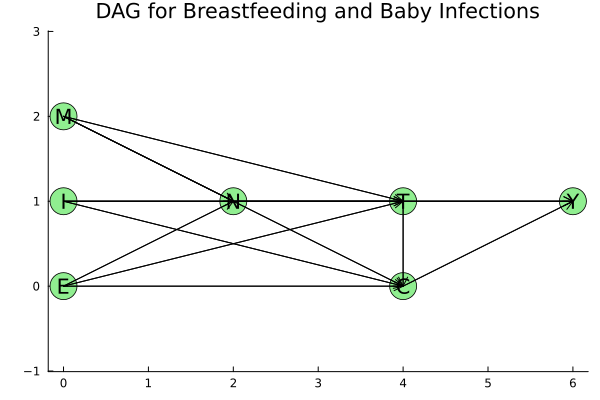

In [24]:
using Graphs
using Plots

# Crear el grafo dirigido
G = DiGraph(7)

# Etiquetas de los nodos (siglas)
labels = Dict(
    1 => "M",  # Marital Status
    2 => "I",  # Family Income
    3 => "E",  # Education
    4 => "N",  # Number of Children
    5 => "T",  # Breastfed
    6 => "C",  # Childcare Outside Home
    7 => "Y"   # Number of Infections
)

# Agregar aristas basadas en el DAG
edges = [
    (1, 5),  # M → T
    (2, 5),  # I → T
    (3, 5),  # E → T
    (4, 5),  # N → T
    (1, 4),  # M → N
    (2, 4),  # I → N
    (3, 4),  # E → N
    (4, 7),  # N → Y
    (6, 7),  # C → Y
    (1, 6),  # M → C
    (2, 6),  # I → C
    (3, 6),  # E → C
    (5, 7),  # T → Y
    (5, 6)   # T → C
]

# Agregar aristas al grafo
for (src, dest) in edges
    add_edge!(G, src, dest)
end

# Coordenadas de los nodos
positions = Dict(
    1 => (0.0, 2.0),  # M
    2 => (0.0, 1.0),  # I
    3 => (0.0, 0.0),  # E
    4 => (2.0, 1.0),  # N
    5 => (4.0, 1.0),  # T
    6 => (4.0, 0.0),  # C
    7 => (6.0, 1.0)   # Y
)

# Extraer nodos y aristas
x_coords = [positions[i][1] for i in 1:nv(G)]
y_coords = [positions[i][2] for i in 1:nv(G)]
edges_coords = [(positions[src][1], positions[src][2], positions[dest][1], positions[dest][2]) for (src, dest) in edges]

# Graficar nodos
scatter(
    x_coords, y_coords,
    label = "",
    color = :lightgreen,
    legend = false,
    markersize = 15,
    title = "DAG for Breastfeeding and Baby Infections",
    grid = false,
    aspect_ratio = :equal
)

# Agregar etiquetas con las siglas
for (i, (x, y)) in enumerate(zip(x_coords, y_coords))
    annotate!(x, y, labels[i])
end

# Graficar aristas
for (x1, y1, x2, y2) in edges_coords
    plot!([x1, x2], [y1, y2], arrow = true, color = :black, lw = 1)
end

# Mostrar el gráfico
display(current())


* **Confounders**:
        
        Age (A): It affects both Smoking Behavior (T) and Lung Function (Y).
        
        Sex (S): It affects both Smoking Behavior (T) and Lung Function (Y).

* **Colliders**:
        
        Smoking Behavior (T): It has arrows coming in from Age (A) and Sex (S).
        
        Lung Function (Y): It has arrows coming in from Height (H) and Smoking Behavior (T).

* **Controls**

        Age (A): It affects both Height (H) and Lung Function (Y) directly. Controlling for age ensures that the causal effect of smoking behavior on lung function is not confounded by age-related differences in height or lung function.

        Sex (S): It influences both Smoking Behavior (T) and Lung Function (Y). Controlling for sex removes bias caused by gender differences in smoking habits or physiological differences affecting lung function.   

* You are trying to study the effect of breast feeding in the number of infections a baby is likely to
have. Your dataset contains the following variables : (5 pts)

        i. Breast fed (Treatment)
        ii. Number of infections of the baby (Outcome)
        iii. Marital status
        iv. Family income
        v. Education
        vi. Number of children in the house
        vii. Childcare outside the home

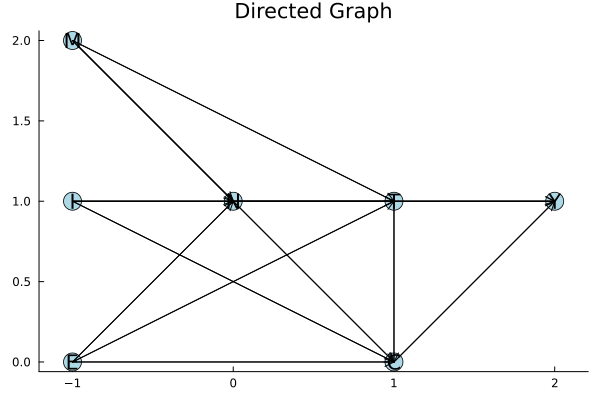

In [22]:
using Graphs
using Plots

# Crear el grafo dirigido
G = DiGraph(7)

# Agregar aristas
edges = [
    (1, 5), (2, 5), (3, 5), (4, 5), # De M, I, E, N → T
    (1, 4), (2, 4), (3, 4),         # De M, I, E → N
    (4, 7),                         # De N → Y
    (6, 7),                         # De C → Y
    (1, 6), (2, 6), (3, 6),         # De M, I, E → C
    (5, 7), (5, 6)                  # De T → Y y T → C
]
for (src, dest) in edges
    add_edge!(G, src, dest)
end

# Coordenadas de los nodos
positions = [
    (-1.0, 2.0),  # M
    (-1.0, 1.0),  # I
    (-1.0, 0.0),  # E
    (0.0, 1.0),   # N
    (1.0, 1.0),   # T
    (1.0, 0.0),   # C
    (2.0, 1.0)    # Y
]

# Etiquetas de los nodos (siglas)
labels = ["M", "I", "E", "N", "T", "C", "Y"]

# Extraer nodos y aristas
x_coords = [pos[1] for pos in positions]
y_coords = [pos[2] for pos in positions]
edges_coords = [(positions[src][1], positions[src][2], positions[dest][1], positions[dest][2]) for (src, dest) in edges]

# Graficar nodos
scatter(
    x_coords, y_coords,
    label = "Nodos",
    color = :lightblue,
    legend = false,
    markersize = 10,
    title = "Directed Graph",
    xlabel = "",
    ylabel = "",
    grid = false,
    aspect_ratio = :equal
)

# Agregar etiquetas con las siglas
for (i, (x, y)) in enumerate(zip(x_coords, y_coords))
    annotate!(x, y, labels[i])
end

# Graficar aristas
for (x1, y1, x2, y2) in edges_coords
    plot!([x1, x2], [y1, y2], arrow = true, color = :black, lw = 1)
end

# Mostrar el gráfico
display(current())


* **Confounders**

        Marital Status (M): Influences both Breastfeeding (T) and Number of Infections (Y) by affecting access to resources and support for childcare.

        Family Income (I): Affects Breastfeeding (T) due to resource availability and Number of Infections (Y) through access to better healthcare and living conditions.

        Education (E): Impacts Breastfeeding (T) as more educated mothers are aware of the benefits and Number of Infections (Y) through better hygiene and healthcare practices.

* **Colliders**
        
        Number of Children (N): It has arrows coming from Marital Status (M), Family Income (I), and Education (E). Conditioning on N would create spurious associations between these variables.

        Childcare Outside Home (C): It has arrows coming from Number of Children (N), Breastfeeding (T), and Family Income (I). Conditioning on C would introduce bias by linking unrelated variables.

* **Controls**

        Marital Status (M): Control this confounder to remove spurious associations with Breastfeeding (T) and Number of Infections (Y).

        Family Income (I): Control this confounder to adjust for its influence on both Breastfeeding (T) and Number of Infections (Y).

        Education (E): Control this confounder to account for its effects on both Breastfeeding (T) and Number of Infections (Y).


## Part 2

In [59]:
using RDatasets, DataFrames, MLJ, MLJDecisionTreeInterface, DecisionTree, StatsPlots, MLJModels

hitters = dataset("ISLR", "Hitters")
hitters[1:5, :]

Row,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Cat…,Cat…,Int32,Int32,Int32,Float64?,Cat…
1,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,missing,A
2,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
3,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
4,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
5,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [60]:
describe(hitters, :nmissing)

#59 salaries missing

Row,variable,nmissing
,Symbol,Int64
1,AtBat,0
2,Hits,0
3,HmRun,0
4,Runs,0
5,RBI,0
6,Walks,0
7,Years,0
8,CAtBat,0
9,CHits,0


In [61]:
hitters = dropmissing(hitters, :Salary);

In [62]:

# Separate the target variable `Salary` and the features
y, X = unpack(hitters, ==(:Salary), !=(:Salary))

# Transform categorical variables to dummies using one-hot encoding
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0
ohe = onehotencoder(features=[:League, :Division, :NewLeague])
ohe_machine = machine(ohe, X)
MLJ.fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);


┌ Info: Training machine(OneHotEncoder(features = [:League, :Division, :NewLeague], …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Spawning 2 sub-features to one-hot encode feature :League.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795
┌ Info: Spawning 2 sub-features to one-hot encode feature :Division.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795
┌ Info: Spawning 2 sub-features to one-hot encode feature :NewLeague.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795


In [63]:
MLJ.schema(X)

┌──────────────┬────────────┬─────────┐
│ names        │ scitypes   │ types   │
├──────────────┼────────────┼─────────┤
│ AtBat        │ Count      │ Int32   │
│ Hits         │ Count      │ Int32   │
│ HmRun        │ Count      │ Int32   │
│ Runs         │ Count      │ Int32   │
│ RBI          │ Count      │ Int32   │
│ Walks        │ Count      │ Int32   │
│ Years        │ Count      │ Int32   │
│ CAtBat       │ Count      │ Int32   │
│ CHits        │ Count      │ Int32   │
│ CHmRun       │ Count      │ Int32   │
│ CRuns        │ Count      │ Int32   │
│ CRBI         │ Count      │ Int32   │
│ CWalks       │ Count      │ Int32   │
│ League__A    │ Continuous │ Float64 │
│ League__N    │ Continuous │ Float64 │
│ Division__E  │ Continuous │ Float64 │
│      ⋮       │     ⋮      │    ⋮    │
└──────────────┴────────────┴─────────┘
                         6 rows omitted


In [64]:
# Coerce counts to continuous variables
MLJ.coerce!(X, Count => MLJ.Continuous)

# Combine `X` and `y` into a single DataFrame
df = hcat(X, y);


In [94]:
train_indices, test_indices = partition(eachindex(y), 0.9, rng=1)
train_df = df[train_indices, :];
test_df = df[test_indices, :];

rename!(train_df, :x1 => :Salary);
rename!(test_df, :x1 => :Salary);

# Transform Salary to LogSalary and then drop Salary
train_df.LogSalary = log.(train_df.Salary)
test_df.LogSalary = log.(test_df.Salary)

select!(train_df, Not(:Salary));
select!(test_df, Not(:Salary));

In [95]:
println(names(train_df))


["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "League__A", "League__N", "Division__E", "Division__W", "PutOuts", "Assists", "Errors", "NewLeague__A", "NewLeague__N", "LogSalary"]


In [96]:
# Fit OLS model with all regressors from training set
fmla = @formula(LogSalary ~ 1 + AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League__A + League__N + Division__E + Division__W + PutOuts + Assists + Errors + NewLeague__A + NewLeague__N)
ols_model= lm(fmla, train_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

LogSalary ~ 1 + AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League__A + League__N + Division__E + Division__W + PutOuts + Assists + Errors + NewLeague__A + NewLeague__N

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                     Coef.     Std. Error       t  Pr(>|t|)      Lower 95%      Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)    0.0          NaN            NaN       NaN     NaN            NaN
AtBat         -0.00300308     0.00127893    -2.35    0.0198   -0.00552379    -0.000482369
Hits           0.013848       0.00475219     2.91    0.0039    0.00448162     0.0232143
HmRun          0.0143693      0.0128716      1.12  

In [97]:
# Calculate the OLS point estimate using the training set
b_hat = GLM.coef(ols_model)

# Number of features (including the intercept)
n_features = length(b_hat)


23

In [98]:
# Bootstrapping
# loop to generate 10,000 bootstrap estimates
n_boots = 10_000
b_boots = zeros(n_boots, n_features)
n_train = nrow(train_df)
Random.seed!(123)  # For reproducibility

for i in 1:n_boots
    # Sample indices with replacement
    indices = rand(1:n_train, n_train)
    boot_df = train_df[indices, :]
    # Fit OLS model on the bootstrap sample
    boot_model = lm(fmla, boot_df)
    # Store the bootstrap coefficients
    b_boots[i, :] = GLM.coef(boot_model)
end

n_b_boots = size(b_boots)


(10000, 23)

In [99]:
# Initialize arrays to store the lower and upper bounds
b_lower = zeros(n_features)
b_upper = zeros(n_features)

# Calculate the 2.5% and 97.5% percentiles for each coefficient
for j in 1:n_features
    b_lower[j] = quantile(b_boots[:, j], 0.025)
    b_upper[j] = quantile(b_boots[:, j], 0.975)
end
length(b_lower)

23

In [100]:
# Calculate confidence intervals
b_conf_lower = b_hat .- b_upper
b_conf_upper = b_hat .- b_lower

# Display the results
coef_names = coefnames(ols_model)
for i in 1:n_features
    println("Coefficient: $(coef_names[i])")
    println("Point Estimate: $(b_hat[i])")
    println("95% Confidence Interval: [$(b_conf_lower[i]), $(b_conf_upper[i])]")
    println()
end

Coefficient: (Intercept)
Point Estimate: 0.0
95% Confidence Interval: [-5.04095559033421, 0.0]

Coefficient: AtBat
Point Estimate: -0.003003080877000832
95% Confidence Interval: [-0.003132829699431419, 0.002782304085091096]

Coefficient: Hits
Point Estimate: 0.013847980469040684
95% Confidence Interval: [-0.01021413388260433, 0.012314851720600572]

Coefficient: HmRun
Point Estimate: 0.014369266563085643
95% Confidence Interval: [-0.022223722247232482, 0.024545385736341532]

Coefficient: Runs
Point Estimate: -0.002227253601035212
95% Confidence Interval: [-0.012118733887187583, 0.011141028608431917]

Coefficient: RBI
Point Estimate: -0.002028846420315926
95% Confidence Interval: [-0.010242957585293994, 0.009027796347411316]

Coefficient: Walks
Point Estimate: 0.011258456969750624
95% Confidence Interval: [-0.006510491415869738, 0.007616700617107296]

Coefficient: Years
Point Estimate: 0.059781031523779025
95% Confidence Interval: [-0.046701667029519646, 0.04645525549964947]

Coefficient

In [103]:
using Statistics

# Predict on the test set
y_pred = MLJModels.predict(ols_model, test_df)

# Calculate the MSE
mse = mean((test_df.LogSalary - y_pred).^2)

println("Out-of-sample MSE: $mse")

Out-of-sample MSE: 0.39155911700950213


In [109]:
# Load the DecisionTreeRegressor
train, test = partition(eachindex(y), 0.9, rng = 1);
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree verbosity=0

tree_model = DecisionTreeRegressor()
tree_machine = machine(tree_model, X[train, :], y[train])
MLJ.fit!(tree_machine)


┌ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


trained Machine; caches model-specific representations of data
  model: DecisionTreeRegressor(max_depth = -1, …)
  args: 
    1:	Source @543 ⏎ Table{AbstractVector{ScientificTypesBase.Continuous}}
    2:	Source @222 ⏎ AbstractVector{ScientificTypesBase.Continuous}


In [110]:
fitted_params(tree_machine)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ CRuns < 64.0
│     │  │  ├─ Hits < 69.5
│     │  │  │  ⋮
│     │  │  │  
│     │  │  └─ Runs < 45.0
│     │  │     ⋮
│     │  │     
│     │  └─ CAtBat < 842.5
│     │     ├─ CRuns < 100.5
│     │     │  ⋮
│     │     │  
│     │     └─ PutOuts < 151.5
│     │        ⋮
│     │        
│     └─ CWalks < 120.0
│        ├─ Walks < 29.5
│        │  ├─ 318.9375 (0/8)
│        │  └─ 215.0 (2/7)
│        └─ Walks < 45.0
│           ├─ 338.5 (0/5)
│           └─ 447.22222222222223 (0/9)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ NewLeague__N < 0.5
   │  │  ├─ Hits < 76.5
   │  │  │  ├─ Errors < 5.5
   │  │  │  │  ⋮
   │  │  │  │  
   │  │  │  └─ 500.4166666666667 (0/6)
   │  │  └─ Years < 12.5
   │  │     ├─ CWalks < 264.5
   │  │     │  ⋮
   │  │     │  
   │  │     └─ PutOuts < 118.0
   │  │        ⋮
   │  │        
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ CWalks

In [112]:
predictions = MLJ.predict(tree_machine, X[test, :])
sqrt(mean((predictions - y[test]) .^ 2))

212.79287325701367

In [116]:

tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = 0.09)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
MLJ.fit!(tree_machine_prune);

thresholds = exp.(collect(-10:0.01:0))
rmses = []

for threshold in thresholds
        tree_model_prune.merge_purity_threshold = threshold
        evaluation = evaluate!(
                tree_machine_prune,
                resampling = CV(nfolds = 3, shuffle = true, rng = 123),
                measure = rmse
        )
        rmses = [rmses; evaluation.measurement]
end

thresholds[argmin(rmses)]



┌ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
Evaluating over 3 folds: 100%[=========================] Time: 0:00:05


0.1998876140751445

In [119]:
tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = thresholds[argmin(rmses)])
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
MLJ.fit!(tree_machine_prune);
predictions_prune = MLJ.predict(tree_machine_prune, X[test, :])
sqrt(mean((predictions_prune - y[test]) .^ 2))

┌ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


212.9207044349215

When comparing the MSE of both models, the bootstrapping model has an MSE of 0.39155911700950213, while the decision tree has an MSE of 212.9207044349215. Since the MSE of the bootstrapping model is lower, this model demonstrates better predictive accuracy according to this metric.






